In [27]:
from imageio import imread
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
from random import random, seed
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
import pandas as pd
from sklearn.utils import resample
from sklearn.model_selection import cross_val_score
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category = ConvergenceWarning)

np.random.seed(2018)

C:\Users\sanfe\AppData\Local\Temp\ipykernel_17612\787212928.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  terrain1 = imread('SRTM_data_Norway_1.tif')


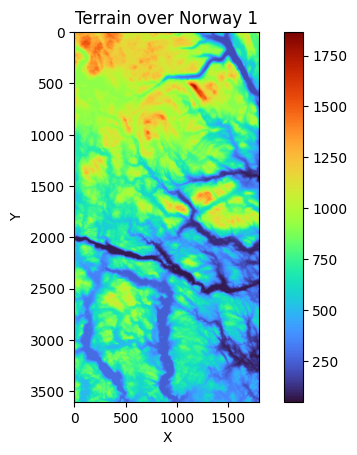

In [3]:
# Load the terrain
terrain1 = imread('SRTM_data_Norway_1.tif')

# Show the terrain
plt.figure()
plt.title('Terrain over Norway 1')
plt.imshow(terrain1, cmap = "turbo")
plt.xlabel('X')
plt.ylabel('Y')
plt.colorbar()
plt.savefig("Terrain_data.png")
plt.show()

In [4]:
terrain1.shape

(3601, 1801)

The dataset is a grid of dimension 3601x1801.

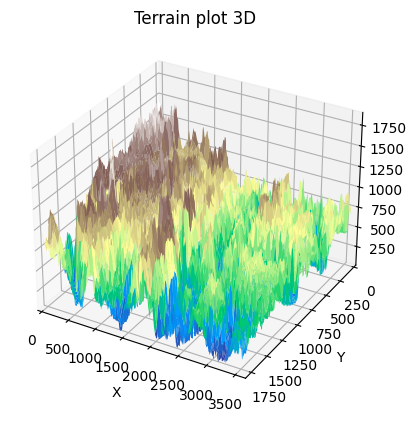

In [5]:
# Represent the entire dataset in a 3D plot, with colors according to the height of the points
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x, y = np.meshgrid(range(3601), range(1801))
surf = ax.plot_surface(x.T, y.T, terrain1, cmap = "terrain")
ax.set_xlim(0, 3601)
ax.set_ylim(1801, 0)
plt.title("Terrain plot 3D")
plt.savefig("Terrain_plot_3D.png")
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

In [6]:
#create design matrix (credits: M. Hjorth-Jensen: Weekly Material, Week 35)
def create_X(x, y, n ):
	if len(x.shape) > 1:
		x = np.ravel(x)
		y = np.ravel(y)

	N = len(x)
	l = int((n+1)*(n+2)/2)
	X = np.ones((N,l))

	for i in range(1,n+1):
		q = int((i)*(i+1)/2)
		for k in range(i+1):
			X[:,q+k] = (x**(i-k))*(y**k)

	return X

# Define a function for Mean Square Error
def MSE(y_data, y_model):
	n = np.size(y_model)
	y_data = y_data.reshape(-1,1)
	y_model = y_model.reshape(-1,1)
	return np.sum((y_data - y_model)**2)/n

# Define a function for R2
def rsquare(y, ypredict):
	ypredict = ypredict.reshape(-1,1)
	return 1-(np.sum((y-ypredict)**2)/np.sum((y-np.mean(y))**2))

# Define a function which applies min-mas scaling
def min_max_scaling(x):
    return (x-min(x))/(max(x)-min(x))

In order to avoid the complications related to the problem of dealing with a high number of data, we considered it useful to reduce the number of points to take into consideration in the analysis by selecting randomly 1500 points from the available data. Afterwards, both the inputs and the output have been scaled using min-max scaling. We decided to apply min-max scaling in order to transform all of our data into values between 0 and 1. In this way, all the data that we have can be compared without problems of any kind.

In [7]:
# Select at random 1500 points from the entire set of points (beacsue there are too many points and otherwise the models will be very slow)
num_points = 1500
points = np.zeros([num_points, 2])
points = np.column_stack((np.random.randint(0, terrain1.shape[0], size = 1500), np.random.randint(0, terrain1.shape[1], size = 1500)))

# The z vector contains only the values relative to the 1500 randomly selected point
z = np.zeros([num_points, 1])
for i in range(num_points):
    z[i] = terrain1[int(points[i,0])][int(points[i,1])]

# Scale the data
z = min_max_scaling(z)
points = np.column_stack((min_max_scaling(points[:,0]), min_max_scaling(points[:,1])))

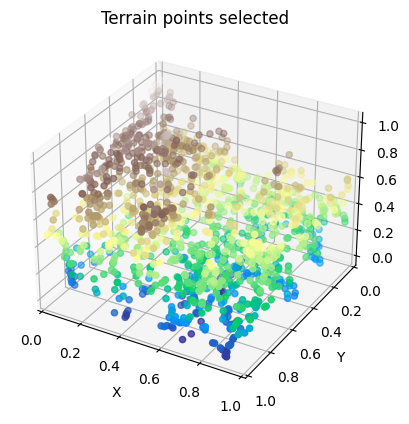

In [8]:
# Represent the selected points into a 3D scatterplot
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
x, y = np.meshgrid(range(3601), range(1801))
ax.scatter(points[:,0], points[:,1], z, cmap = "terrain", c = z) # Create a scatterplot with colors according to the height of the point
plt.title("Terrain points selected")
ax.set_xlim(0, 1)
ax.set_ylim(1, 0)
plt.xlabel('X')
plt.ylabel('Y')
plt.savefig("Terrain_points_selected.png")
plt.show()

**OLS**

In [9]:
maxdegree = 20

# Create the design matrix
X = create_X(points[:, 0], points[:, 1], maxdegree)

# Removing the intercept column
X = X[:, 1:]

# Split in train and test data
x_train, x_test, z_train, z_test = train_test_split(X, z, test_size = 0.2)

In [10]:
rsqr_train = np.zeros(maxdegree)
train_mse = np.zeros(maxdegree)
rsqr_test = np.zeros(maxdegree)
test_mse = np.zeros(maxdegree)

for deg in range(1, maxdegree+1):
        c = int((deg+2)*(deg+1)/2)
        X_tilde = x_train[:,0:c-1]
        model = LinearRegression(fit_intercept = True)
        model.fit(X_tilde, z_train)

        z_tilde = model.predict(X_tilde)
        z_predict = model.predict(x_test[:,0:c-1])

        train_mse[deg-1] = (MSE(z_train, z_tilde))
        test_mse[deg-1] = (MSE(z_test, z_predict))
        rsqr_train[deg-1]= rsquare(z_train, z_tilde)
        rsqr_test[deg-1]= rsquare(z_test, z_predict)

In [11]:
test_mse

array([0.02720501, 0.02655141, 0.02360067, 0.02286787, 0.02283993,
       0.02128837, 0.02050556, 0.02114069, 0.01915089, 0.01793562,
       0.0168157 , 0.01593489, 0.01368949, 0.01300034, 0.01248256,
       0.01305146, 0.01361884, 0.01579825, 0.01370759, 0.01905746])

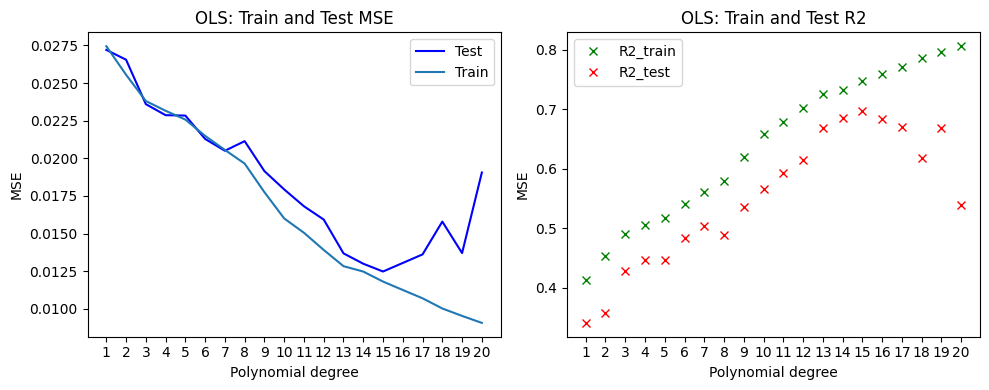

In [12]:
fig, axs = plt.subplots(1, 2, figsize = (10, 4))  

# Plot for lambda = 0.0001
axs[0].plot(range(1,maxdegree+1),test_mse,color='b',label="Test")
axs[0].plot(range(1,maxdegree+1),train_mse,label="Train")
axs[0].set_xlabel('Polynomial degree')
axs[0].set_ylabel('MSE')
axs[0].set_xticks(ticks = range(1, maxdegree + 1))
axs[0].set_title('OLS: Train and Test MSE')
axs[0].legend()

# Plot for lambda = 572236.765935022
axs[1].plot(range(1,maxdegree+1),rsqr_train, 'gx', label = 'R2_train')
axs[1].plot(range(1,maxdegree+1),rsqr_test, 'rx', label = 'R2_test')
axs[1].set_xlabel('Polynomial degree')
axs[1].set_ylabel('MSE')
axs[1].set_title('OLS: Train and Test R2')
axs[1].set_xticks(ticks = range(1, maxdegree + 1))
axs[1].legend()

plt.tight_layout()
plt.savefig("OLS.png")

# Show the figure
plt.show()

We can observe that the test error is higher than the train error for higher complexities. The positive aspect is that, up to degree 16, both train and test error have a decreasing trend, thus confirming that complexity reduces the MSEs. From degree 17, while the train error keeps getting better and better, the test error start to become worse than before. This is due to the phenomenon of overfitting: since the model with high complexity is constructed to perform very well with the test data, when it deals with a new sample of points (the test sample), its performance accuracy is reduced. 

On the contrary, looking at the $R^2$ plot, the value corresponding to the train sample are generally better than the ones related to the test sample. With both the samples the coefficient increases going from degree 1 to degree 14. Again, from degree 15 there is a change in the behavior of the $R^2$ value related to the test set: it starts decreasing. This behavior reflects perfectly what we have just seen for the test MSE: the overfitting problems comes in place again.

In [13]:
np.argmin(test_mse)+1

15

The minimum value of the MSE for the test sample is obtained with a polynomial degree of 15. With this degree, also the train MSE is low. For this reason, a good choice is to apply OLS with degree 15. 

**Ridge**

The second step consists in applying Ridge Regression: the model has been applied with different values of $\lambda$, but also with different polynomial degrees. 

In [17]:
# Set the values of lambda
nlambdas = 100
lambdas = np.logspace(-5, 5, nlambdas)

MSE_train_Ridge = np.zeros((nlambdas, maxdegree))
MSE_test_Ridge = np.zeros((nlambdas, maxdegree))
rsqr_train_Ridge = np.zeros((nlambdas, maxdegree))
rsqr_test_Ridge = np.zeros((nlambdas, maxdegree))

# Apply ridge for every combination of polynomial degree and lambda
for j in range(nlambdas):
    for i in range(1, maxdegree+1):
            c = int((i+2)*(i+1)/2)
            X_tilde = x_train[:,0:c-1]

            Ridge = linear_model.Ridge(lambdas[j], max_iter = 1000)
            Ridge.fit(X_tilde, z_train)
            z_tilde = Ridge.predict(X_tilde)
            z_predict = Ridge.predict(x_test[:,0:c-1])

            # Store the values of MSE and R2
            MSE_train_Ridge[j, i-1] = MSE(z_train, z_tilde)
            MSE_test_Ridge[j, i-1] = MSE(z_test, z_predict)

In [18]:
MSE_test_Ridge

array([[0.02720501, 0.02655141, 0.02360071, ..., 0.01961454, 0.01956349,
        0.0195789 ],
       [0.02720501, 0.02655141, 0.02360072, ..., 0.01969017, 0.0196151 ,
        0.01961376],
       [0.02720501, 0.02655141, 0.02360074, ..., 0.01978145, 0.01968049,
        0.01965864],
       ...,
       [0.0412759 , 0.04120859, 0.04114601, ..., 0.04081094, 0.04080306,
        0.0407958 ],
       [0.0412864 , 0.04123297, 0.0411832 , ..., 0.04091444, 0.04090805,
        0.04090216],
       [0.04129474, 0.04125233, 0.04121278, ..., 0.04099774, 0.04099258,
        0.04098782]])

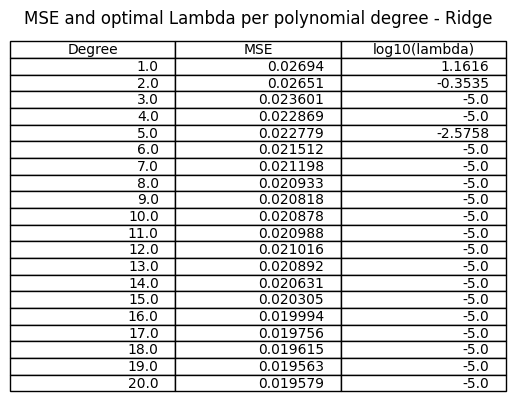

In [44]:
MSE_Ridge_df = pd.DataFrame(MSE_test_Ridge, index = lambdas, columns = range(1, maxdegree+1))
MSE_Ridge_df = MSE_Ridge_df.T

# Create new columns "MSE" and "lambda" containing the minimum value for each row and the lambda value respectively
MSE_Ridge_df[["MSE", "log10(lambda)"]] = MSE_Ridge_df.apply(lambda row: pd.Series([round(row.min(), 6), round(np.log10(row.idxmin()), 4)]), axis=1)

# Drop the original columns to keep only MSE and lambda columns
MSE_Ridge_df.drop(MSE_Ridge_df.columns.difference(["MSE", "log10(lambda)"]), axis=1, inplace=True)

MSE_Ridge_df["Degree"] = MSE_Ridge_df.index
MSE_Ridge_df = MSE_Ridge_df[["Degree", "MSE", "log10(lambda)"]]

# Save the table
fig, ax = plt.subplots(1, 1)
ax.axis('off')
ax.axis('tight')
ax.table(cellText = MSE_Ridge_df.values, colLabels = MSE_Ridge_df.columns, loc = 'center')
ax.set_title("MSE and optimal Lambda per polynomial degree - Ridge")
plt.savefig("Ridge_table.png")
plt.show()

The above table shows the values of $log_{10}(\lambda)$ that minimize the test MSE for each polynomial degree, together with the correspondent MSE value. Even in this case, as for OLS, when the model complexity increases, the MSE tends to decrease. The optimal values of MSE are obtained with differnt values of $\lambda$, but almost all of them correspond to $\lambda = 10^{-5}$. That is why we now show the plots of MSE and polynomial degree for this value of $\lambda$, compared with the same graph plotted with a different value of $\lambda$. The goal is to see the difference between the two cases.

In [20]:
print("Lambda 1:", lambdas[0])
print("Lambda 2:", lambdas[49])

Lambda 1: 1e-05
Lambda 2: 0.8902150854450392


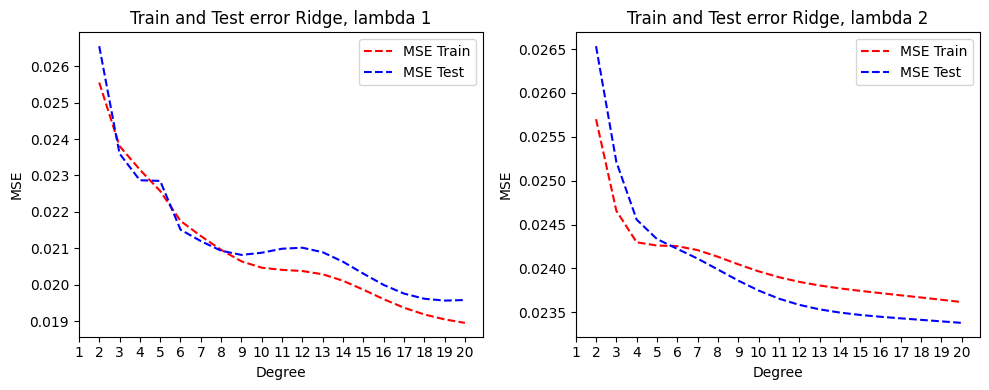

In [21]:
fig, axs = plt.subplots(1, 2, figsize = (10, 4))  

# Plot for lambda = 1e-05
axs[0].plot(range(2, maxdegree + 1), MSE_train_Ridge[0][1:], 'r--', label='MSE Train')
axs[0].plot(range(2, maxdegree + 1), MSE_test_Ridge[0][1:], 'b--', label='MSE Test')
axs[0].set_xlabel('Degree')
axs[0].set_ylabel('MSE')
axs[0].set_xticks(ticks = range(1, maxdegree + 1))
axs[0].set_title('Train and Test error Ridge, lambda 1')
axs[0].legend()

# Plot for lambda = 0.8902150854450392
axs[1].plot(range(2, maxdegree + 1), MSE_train_Ridge[49][1:], 'r--', label='MSE Train')
axs[1].plot(range(2, maxdegree + 1), MSE_test_Ridge[49][1:], 'b--', label='MSE Test')
axs[1].set_xlabel('Degree')
axs[1].set_ylabel('MSE')
axs[1].set_title('Train and Test error Ridge, lambda 2')
axs[1].set_xticks(ticks = range(1, maxdegree + 1))
axs[1].legend()

plt.tight_layout()
plt.savefig("Ridge_lambda_comparison.png")

# Show the figure
plt.show()

The graphs represent the MSE for Ridge regression with different values of $\lambda$, according to the polynomial degree. The figure on the left is computed with the first value of $\lambda$, i.e. $\lambda = 10^{-5}$, while the second one corresponds to an intermediate value: $\lambda = 0.8902150854450392$, which correspond to the $50^{th}$ value of the tested lambdas. Looking at the two graphs together, it can be immediately noticed that their shape is similar: they both start with high levels of MSE for low polynomial degrees, but as long as the complexity increase, the error decreases. With the first value of $\lambda$, the MSE is always lower than for the second case, which means that the first model is better than the second one. Moreover, while in the first plot, the test MSE exceeds the train MSE for polynomial of degree higher than 8, in the second plot the situation is different. In this case, if for low complexity the test error is worse than the train error, as the degree increases, the train error increases too, exceeding the test error from degree 6 onwards. This can happen: we are also talking about a very small difference between train and test errors. 

**Lasso**

The next step consists in applying Lasso Regression: the model has been applied with different values of $\lambda$, but also with different polynomial degrees. 

In [29]:
# Set the values of lambda
nlambdas = 100
lambdas = np.logspace(-5, 5, nlambdas)

MSE_train_Lasso = np.zeros((nlambdas, maxdegree))
MSE_test_Lasso = np.zeros((nlambdas, maxdegree))
rsqr_train_Lasso = np.zeros((nlambdas, maxdegree))
rsqr_test_Lasso = np.zeros((nlambdas, maxdegree))

# Apply ridge for every combination of polynomial degree and lambda
for j in range(nlambdas):
    for i in range(1, maxdegree+1):
            c = int((i+2)*(i+1)/2)
            X_tilde = x_train[:, 0:c-1]
            
            RegLasso = linear_model.Lasso(lambdas[j], max_iter = 1000)
            RegLasso.fit(X_tilde, z_train)

            ypredict_Lasso = RegLasso.predict(X_tilde)
            ypredict_test_Lasso = RegLasso.predict(x_test[:, 0:c-1])

            # Store the values of MSE and R2
            MSE_train_Lasso[j, i-1] = MSE(z_train, ypredict_Lasso)
            MSE_test_Lasso[j, i-1] = MSE(z_test, ypredict_test_Lasso)
            rsqr_train_Lasso[j, i-1] = rsquare(z_train, ypredict_Lasso)
            rsqr_test_Lasso[j, i-1] = rsquare(z_test, ypredict_test_Lasso)

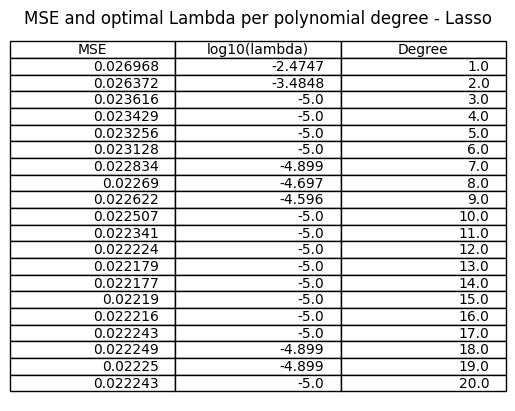

In [47]:
MSE_Lasso_df = pd.DataFrame(MSE_test_Lasso, index = lambdas, columns = range(1, maxdegree + 1))
MSE_Lasso_df = MSE_Lasso_df.T

# Create a new column "MSE" containing the minimum value for each row
MSE_Lasso_df[["MSE", "log10(lambda)"]] = MSE_Lasso_df.apply(lambda row: pd.Series([round(row.min(), 6), round(np.log10(row.idxmin()), 4)]), axis = 1)

# Drop the original columns to keep only MSE and lambda columns
MSE_Lasso_df.drop(MSE_Lasso_df.columns.difference(["MSE", "log10(lambda)"]), axis = 1, inplace = True)

MSE_Lasso_df["Degree"] = MSE_Ridge_df.index
MSE_Ridge_df = MSE_Ridge_df[["Degree", "MSE", "log10(lambda)"]]

# Save the table
fig, ax = plt.subplots(1, 1)
ax.axis('off')
ax.axis('tight')
ax.table(cellText = MSE_Lasso_df.values, colLabels = MSE_Lasso_df.columns, loc = 'center')
ax.set_title("MSE and optimal Lambda per polynomial degree - Lasso")
plt.savefig("Lasso_table.png")
plt.show()

As for Ridge Regression, for Lasso Regression we created a table to compare the values of lambda minimizing the MSE for each polynomial degree. As we can see from the figure, the majority of the best values of MSE are given by the same value of $\lambda$: $\lambda = 10^{-5}$. Even all the other values correspond to lambdas very close to this value. In general, we can notice that the MSE is larger than in the previous case, meaning that Lasso is working worser with our data.

In [31]:
print("Lambda 1:", lambdas[0])
print("Lambda 2:", lambdas[49])

Lambda 1: 1e-05
Lambda 2: 0.8902150854450392


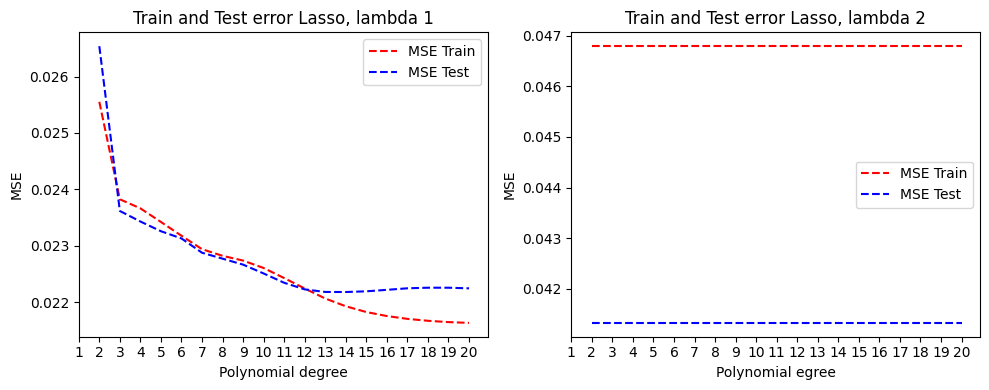

In [32]:
fig, axs = plt.subplots(1, 2, figsize = (10, 4)) 

# Plot for lambda = 1e-05
axs[0].plot(range(2, maxdegree + 1), MSE_train_Lasso[0][1:], 'r--', label='MSE Train')
axs[0].plot(range(2, maxdegree + 1), MSE_test_Lasso[0][1:], 'b--', label='MSE Test')
axs[0].set_xlabel('Polynomial degree')
axs[0].set_ylabel('MSE')
axs[0].set_xticks(ticks = range(1, maxdegree + 1))
axs[0].set_title('Train and Test error Lasso, lambda 1')
axs[0].legend()

# Plot for lambda = 0.8902150854450392
axs[1].plot(range(2, maxdegree + 1), MSE_train_Lasso[49][1:], 'r--', label='MSE Train')
axs[1].plot(range(2, maxdegree + 1), MSE_test_Lasso[49][1:], 'b--', label='MSE Test')
axs[1].set_xlabel('Polynomial egree')
axs[1].set_ylabel('MSE')
axs[1].set_title('Train and Test error Lasso, lambda 2')
axs[1].set_xticks(ticks = range(1, maxdegree + 1))
axs[1].legend()

plt.tight_layout()
plt.savefig("Lasso_lambda_comparison.png")

# Show the figure
plt.show()

We decided to analyze the same values of $\lambda$ as in Ridge regression in order to compare the results and see what changes here. For the first plot, the result is more or less the same as before: both train and test errors decrease with the increase of the polynomial degree. Around a degree equal to 13, the test error starts to be worse than the train error, thus confirming what has been seen before with both OLS and Ridge (overfitting phenomenon). 

On the contrary, the second figure appears completely different: here the errors are stable for all the degrees. Moreover, the train MSE is larger, even if just a bit, than the test MSE. This can be due to the fact that the best Lasso models in this case are obtained with small values of $\lambda$. Consequently, increasing lambda creates worse results, which generates different trends in the errors.

**Comparison**

Finally, we can make a comparison between the three methods. We decided to evaluate their performance with a polynomial degree equal to 15 (which was the optimal value in OLS). The following figure allows to compare the Mean Squared Errors obtained with the three different methods, for different values of $\lambda$ for Ridge and Lasso. 

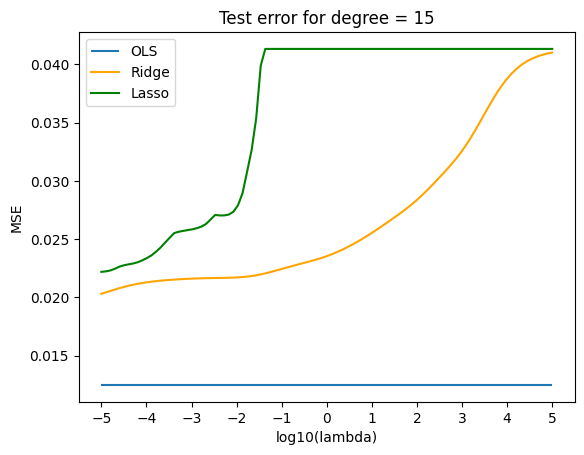

In [48]:
degree = 15

plt.figure()
plt.hlines(test_mse[14], -5, 5, label = 'OLS')
plt.plot(np.log10(lambdas), MSE_test_Ridge[:, 14], 'orange', label = 'Ridge')
plt.plot(np.log10(lambdas), MSE_test_Lasso[:, 14], 'green', label = 'Lasso')
plt.xlabel('log10(lambda)')
plt.xticks(ticks = range(-5,6))
plt.ylabel('MSE')
plt.title('Test error for degree = 15')
plt.legend()
plt.savefig("Test error for degree = 15.png")
plt.show()

As expected, the OLS regression, producing a MSE even  lower than 0.015, results to be the best model with our data. The other methods are worse for each value of $\lambda$: even if they perform better with low calues of $\lambda$, their performance is not comparable to OLS, which gives a smaller error. For large values of $\lambda$ to MSE of both Ridge and Lasso start decresing, until reaching a plateau. 

Bias-Variance tradeoff

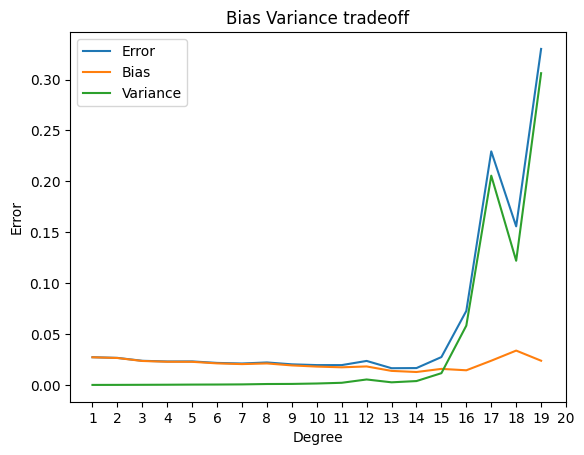

In [1082]:
n_boostraps = 100
z_pred = np.empty((len(z_test), n_boostraps))

maxdegree = 20

error = np.zeros(maxdegree)
bias = np.zeros(maxdegree)
variance = np.zeros(maxdegree)
polydegree = np.zeros(maxdegree)

for degree in range(1, maxdegree+1):
    model = LinearRegression(fit_intercept = True)
    y_pred = np.empty((z_test.shape[0], n_boostraps))
    c = int((degree+2)*(degree+1)/2)
    X_tilde = x_train[:, 0:c-1]
    for i in range(n_boostraps):
        x_, y_ = resample(X_tilde, z_train)
        y_pred[:, i] = model.fit(x_, y_).predict(x_test[:, 0:c-1]).ravel()

    polydegree[degree] = degree
    error[degree] = np.mean( np.mean((z_test - y_pred)**2, axis = 1, keepdims = True) )
    bias[degree] = np.mean( (z_test - np.mean(y_pred, axis = 1, keepdims = True))**2 )
    variance[degree] = np.mean( np.var(y_pred, axis = 1, keepdims = True) )

plt.plot(polydegree[1:], error[1:], label = 'Error')
plt.plot(polydegree[1:], bias[1:], label = 'Bias')
plt.plot(polydegree[1:], variance[1:], label = 'Variance')
plt.xticks(ticks = range(1,maxdegree+1))
plt.legend()
plt.xlabel("Polynomial degree")
plt.ylabel("Error")
plt.title("Bias Variance tradeoff")
plt.savefig("Bias_Variance_tradeoff.png")
plt.show()

The phenomenon of overfitting can be further analyzed by studying the decomposition of the MSE into Bias and Variance. The above figure shows exactly what we want to depict: the so-called Bias-Variance tradeoff. Focusing on the left part of the plot, with small polynomial degrees, we can notice that the variance is equal to 0 (until degree = 11), while the bias is a bit higher. Here only the bias gives a contribution to the error, meaning that we are "underfitting" our model. As the complexity of the model increases (i.e as the polynomial degree increases), the variance of the model, starting from very low values, increases sharply. This worsening in variance, particularly visible for the highest degrees, is due again to the overfitting problem. While the Bias is more or less stable, the variance is largely affected by a too close adaption of the model to the training set. As a consequence, even small changes in the data bring significant changes to the model for large polynomial degrees. The turning point, where the overfitting phenomenon arises is around degree 14/15. This confirms what has been seen in the previous plots: the test MSE and the test $R^2$ started to get worse around the same degree. 